In [1]:
import pandas as pd
import numpy as np

In [2]:
YK_label = pd.read_excel('../data/YK_LABEL.xlsx')
YK_data = pd.read_csv('../data/YK_training_ULT.csv')

In [3]:
#Looking at the shape of each dataset
print(YK_data.shape)

(69577, 1076)


In [4]:
#Function to drop columns (tests) in the raw data file which are NOT tests (i.e metadata like start time, lot number etc)
def test_only(datafile,labelfile):
    keys = list(labelfile['Name'])
    df = datafile[keys]
    return df

In [5]:
#Applying the functions to file 
YK_dropped = test_only(YK_data,YK_label)
#Checking the shape and how the data looks like
print(YK_dropped.shape)
print(YK_dropped.head())

(69577, 1039)
   temperature  Device_Test_Time  \
0         25.0           22332.0   
1         25.0           11976.0   
2         25.0           11920.0   
3         25.0            9224.0   
4         25.0           11936.0   

   otp_read_line0_stdf_:ULT_Chksum@ULT_Chksum[1]  Part_Id  \
0                                            NaN      1.0   
1                                            NaN      2.0   
2                                            NaN      3.0   
3                                            NaN      4.0   
4                                            NaN      5.0   

   otp_read_blank:Functional[1]  g2bist_efuse_blank_read_f_:Functional[1]  \
0                           NaN                                       NaN   
1                           NaN                                       NaN   
2                           NaN                                       NaN   
3                           NaN                                       NaN   
4                

## Identify the applicable columns (i.e those with a label)
Those without a label will be dropped, since there will not be any response variable (distribution of categories) to predict the predictor variable (data points)

In [6]:
#Function to find out non applicable rows (no distribution, not part of training data)
def non_applicable (df_label):
    null_rowsLabel = df_label[df_label['Distribution Type'].isnull()]
    null_rowsLabel = list(null_rowsLabel['Name'])
    return null_rowsLabel

In [7]:
#Applying the above function to set of data
YK_non_applicable = non_applicable(YK_label)
#Printing the tests (columns) to see which tests do not have a distribution (i.e not applicable)
print(YK_non_applicable)
print(len(YK_non_applicable))

['otp_read_line0_stdf_:ULT_Chksum@ULT_Chksum[1]', 'otp_read_blank:Functional[1]', 'tdf_50k_1_f_:Functional[1]', 'tdf_50k_4_f_:Functional[1]', 'tdf_50k_9_f_:Functional[1]', 'tdf_50k_8_f_:Functional[1]', 'otp_read_line0_sva_f_:Functional[1]', 'tdf_50k_10_f_:Functional[1]', 'tdf_90k_2_f_:Functional[1]', 'tdf_90k_7_f_:Functional[1]', 'tdf_90k_8_f_:Functional[1]', 'tdf_90k_10_f_:Functional[1]', 'tdf_90k_11_f_:Functional[1]', 'tdf_90k_15_f_:Functional[1]']
14


## Pre-processing the label file
The codes above are for the raw data (The data points for each test).The labels under the label file (YK_label) are the categorical variables denoting the distribution of each test (each column in the raw data file). There are 6 labels/distribution categories - outlier, normal, longtail, functional, discrete and bimodal. Now we will process the label files and identify those rows where there are no distribution (not applicable) and proceed to drop them. 

In [8]:
#Function to faciliate the dropping of the null rows in labels file
def drop_null_labels(label_df,not_applicable):
    df = label_df.drop(label_df[label_df.Name.isin(not_applicable)].index)
    return df

In [9]:
#Applying it to set of data
YK_label_final = drop_null_labels(YK_label,YK_non_applicable)
YK_label_final

,Name,Mean,Standard Deviation,Distribution Type
0,temperature,25.000000,0.000000,functional
1,Device_Test_Time,16119.452606,1143.346961,longtail
3,Part_Id,7088.813185,4964.820066,longtail
5,g2bist_efuse_blank_read_f_:Functional[1],-1.000000,0.000000,functional
7,tdf_50k_2_f_:Functional[1],-0.750000,0.500000,functional
...,...,...,...,...
1034,tdf_90k_5_p_:Functional[1],-1.000000,0.000000,functional
1035,tdf_90k_6_p_:Functional[1],-1.000000,0.000000,functional
1036,tdf_90k_7_p_:Functional[1],-1.000000,0.000000,functional
1037,tdf_90k_8_p_:Functional[1],-1.000000,0.000000,functional


In [10]:
YK_target = YK_label_final[['Name','Distribution Type']]
YK_target

,Name,Distribution Type
0,temperature,functional
1,Device_Test_Time,longtail
3,Part_Id,longtail
5,g2bist_efuse_blank_read_f_:Functional[1],functional
7,tdf_50k_2_f_:Functional[1],functional
...,...,...
1034,tdf_90k_5_p_:Functional[1],functional
1035,tdf_90k_6_p_:Functional[1],functional
1036,tdf_90k_7_p_:Functional[1],functional
1037,tdf_90k_8_p_:Functional[1],functional


In [11]:
YK_transposed = YK_dropped.T.reset_index(inplace=False, drop=False)

YK_transposed.columns = ['Name'] + [i for i in range(1, len(YK_transposed.columns))]
YK_transposed

,Name,1,2,3,4,5,6,7,8,9,...,69568,69569,69570,69571,69572,69573,69574,69575,69576,69577
0,temperature,25.0,25.0,25.0,25.0,25.0,25.0,25.0,25.0,25.0,...,25.0,25.0,25.0,25.0,25.0,25.0,25.0,25.0,25.0,25.0
1,Device_Test_Time,22332.0,11976.0,11920.0,9224.0,11936.0,11914.0,11893.0,11904.0,11882.0,...,9833.0,12648.0,12648.0,12648.0,12648.0,12648.0,12648.0,12648.0,4375.0,4375.0
2,otp_read_line0_stdf_:ULT_Chksum@ULT_Chksum[1],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Part_Id,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,312.0,313.0,314.0,315.0,316.0,317.0,318.0,319.0,320.0,321.0
4,otp_read_blank:Functional[1],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1034,tdf_90k_5_p_:Functional[1],-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,NaN,NaN,NaN,NaN,NaN,-1.0,-1.0,NaN,NaN,NaN
1035,tdf_90k_6_p_:Functional[1],-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,NaN,NaN,-1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN
1036,tdf_90k_7_p_:Functional[1],-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,NaN,NaN,-1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN
1037,tdf_90k_8_p_:Functional[1],-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,NaN,NaN,-1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN


In [12]:
#Combined dataframe of X and Y
df_merged = pd.merge(YK_target, YK_transposed, on='Name', how='inner')

In [13]:
df_yk = df_merged.T
df_yk

,0,1,2,3,4,5,6,7,8,9,...,1015,1016,1017,1018,1019,1020,1021,1022,1023,1024
Name,temperature,Device_Test_Time,Part_Id,g2bist_efuse_blank_read_f_:Functional[1],tdf_50k_2_f_:Functional[1],stf_50k_1_f_:Functional[1],write_dro_sidd:Functional[1],brf1_fsm_tx_:Functional[1],otp_array_readout_min:Functional[1],bbud_lpbk_min:Functional[1],...,tdf_90k_18_p_:Functional[1],tdf_90k_1_p_:Functional[1],tdf_90k_2_p_:Functional[1],tdf_90k_3_p_:Functional[1],tdf_90k_4_p_:Functional[1],tdf_90k_5_p_:Functional[1],tdf_90k_6_p_:Functional[1],tdf_90k_7_p_:Functional[1],tdf_90k_8_p_:Functional[1],tdf_90k_9_p_:Functional[1]
Distribution Type,functional,longtail,longtail,functional,functional,functional,functional,functional,functional,functional,...,functional,functional,functional,functional,functional,functional,functional,functional,functional,functional
1,25.0,22332.0,1.0,NaN,NaN,NaN,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,25.0,11976.0,2.0,NaN,NaN,NaN,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,25.0,11920.0,3.0,NaN,NaN,NaN,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69573,25.0,12648.0,317.0,NaN,NaN,NaN,-1.0,-1.0,-1.0,-1.0,...,NaN,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
69574,25.0,12648.0,318.0,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,...,NaN,-1.0,-1.0,-1.0,-1.0,-1.0,NaN,NaN,NaN,NaN
69575,25.0,12648.0,319.0,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,...,NaN,-1.0,-1.0,-1.0,-1.0,NaN,NaN,NaN,NaN,NaN
69576,25.0,4375.0,320.0,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
features_yk = df_yk.iloc[2:]
features_yk

,0,1,2,3,4,5,6,7,8,9,...,1015,1016,1017,1018,1019,1020,1021,1022,1023,1024
1,25.0,22332.0,1.0,NaN,NaN,NaN,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,25.0,11976.0,2.0,NaN,NaN,NaN,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,25.0,11920.0,3.0,NaN,NaN,NaN,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,25.0,9224.0,4.0,NaN,NaN,NaN,-1.0,-1.0,NaN,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
5,25.0,11936.0,5.0,NaN,NaN,NaN,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69573,25.0,12648.0,317.0,NaN,NaN,NaN,-1.0,-1.0,-1.0,-1.0,...,NaN,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
69574,25.0,12648.0,318.0,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,...,NaN,-1.0,-1.0,-1.0,-1.0,-1.0,NaN,NaN,NaN,NaN
69575,25.0,12648.0,319.0,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,...,NaN,-1.0,-1.0,-1.0,-1.0,NaN,NaN,NaN,NaN,NaN
69576,25.0,4375.0,320.0,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
labels_yk = df_yk.iloc[:2]
labels_yk

,0,1,2,3,4,5,6,7,8,9,...,1015,1016,1017,1018,1019,1020,1021,1022,1023,1024
Name,temperature,Device_Test_Time,Part_Id,g2bist_efuse_blank_read_f_:Functional[1],tdf_50k_2_f_:Functional[1],stf_50k_1_f_:Functional[1],write_dro_sidd:Functional[1],brf1_fsm_tx_:Functional[1],otp_array_readout_min:Functional[1],bbud_lpbk_min:Functional[1],...,tdf_90k_18_p_:Functional[1],tdf_90k_1_p_:Functional[1],tdf_90k_2_p_:Functional[1],tdf_90k_3_p_:Functional[1],tdf_90k_4_p_:Functional[1],tdf_90k_5_p_:Functional[1],tdf_90k_6_p_:Functional[1],tdf_90k_7_p_:Functional[1],tdf_90k_8_p_:Functional[1],tdf_90k_9_p_:Functional[1]
Distribution Type,functional,longtail,longtail,functional,functional,functional,functional,functional,functional,functional,...,functional,functional,functional,functional,functional,functional,functional,functional,functional,functional


In [16]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
normalized_data = scaler.fit_transform(features_yk)

In [17]:
scaled_features_yk = pd.DataFrame(normalized_data)
scaled_features_yk

,0,1,2,3,4,5,6,7,8,9,...,1015,1016,1017,1018,1019,1020,1021,1022,1023,1024
0,0.0,5.433689,-1.427618,NaN,NaN,NaN,0.0,0.0,0.0,-0.013989,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,-3.623994,-1.427416,NaN,NaN,NaN,0.0,0.0,0.0,-0.013989,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,-3.672973,-1.427215,NaN,NaN,NaN,0.0,0.0,0.0,-0.013989,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,-6.030980,-1.427013,NaN,NaN,NaN,0.0,0.0,NaN,-0.013989,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,-3.658979,-1.426812,NaN,NaN,NaN,0.0,0.0,0.0,-0.013989,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69572,0.0,-3.036242,-1.363969,NaN,NaN,NaN,0.0,0.0,0.0,-0.013989,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69573,0.0,-3.036242,-1.363768,NaN,NaN,NaN,0.0,NaN,NaN,NaN,...,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
69574,0.0,-3.036242,-1.363566,NaN,NaN,NaN,0.0,NaN,NaN,NaN,...,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
69575,0.0,-10.272067,-1.363365,NaN,NaN,NaN,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
from scipy.stats import skew, kurtosis, norm, kstest, zscore
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import warnings

def statistical_features(df):
    feature_vectors = []

    for column in df.columns:
        values = df[column].dropna()

        mean = values.mean()
        median = values.median()
        std_dev = values.std()
        iqr = values.quantile(0.75) - values.quantile(0.25)
        # skewness = skew(values)
        # kurt = kurtosis(values)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            try:
                skewness = skew(values)
                kurt = kurtosis(values)
            except RuntimeWarning:
                skewness = np.nan
                kurt = np.nan
        min_value = values.min()
        max_value = values.max()
        range = max_value - min_value
        p95 = values.quantile(0.95)
        p5 = values.quantile(0.05)
        percentile_ratio = p95 / p5 if p5 != 0 else np.nan
        tail_weight_ratio = np.sum((values > (median + 1.5*iqr)) | (values < (median - 1.5*iqr))) / len(values)
        excess_kurtosis = kurt - 3
        p99 = values.quantile(0.99)
        p1 = values.quantile(0.01)

        feature_vector = {
            'Mean': mean,
            'Median': median,
            'Std_Dev': std_dev,
            'IQR': iqr,
            'Skewness': skewness,
            'Kurtosis': kurt,
            'Min': min_value,
            'Max': max_value,
            'Range': range,
            'Percentile_Ratio_95_5': percentile_ratio,
            'Tail_Weight_Ratio': tail_weight_ratio,
            'Excess_Kurtosis': excess_kurtosis,
            'P99': p99,
            'P1': p1
        }
        feature_vectors.append(feature_vector)

    features_df = pd.DataFrame(feature_vectors)
    return features_df

In [35]:
statistical_features = statistical_features(scaled_features_yk)
statistical_features.head()

,Mean,Median,Std_Dev,IQR,Skewness,Kurtosis,Min,Max,Range,Percentile_Ratio_95_5,Tail_Weight_Ratio,Excess_Kurtosis,P99,P1
0,0.000000e+00,0.000000,0.000000,0.000000,NaN,NaN,0.000000,0.000000,0.000000,NaN,0.000000,NaN,0.000000,0.000000
1,1.830048e-16,0.252373,1.000007,0.443438,-6.338681,49.533672,-12.225994,9.234837,21.460831,-0.983337,0.079063,46.533672,0.687064,-5.402994
2,1.045742e-16,-0.129072,1.000007,1.597451,0.435881,-0.729177,-1.427618,2.492794,3.920412,-1.302537,0.016112,-3.729177,2.352655,-1.418352
3,0.000000e+00,0.000000,0.000000,0.000000,NaN,NaN,0.000000,0.000000,0.000000,NaN,0.000000,NaN,0.000000,0.000000
4,-5.551115e-17,-0.577350,1.154701,0.577350,1.154701,-0.666667,-0.577350,1.732051,2.309401,-2.400000,0.250000,-3.666667,1.662769,-0.577350


In [20]:
from scipy.stats import norm, kstest, zscore
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

def outlier_detection(df):
    feature_vectors = []
    
    for column in df.columns:
        values = df[column].dropna()

        # Outlier detection using z-score
        zscores = zscore(values)
        outliers_zscore = zscores.abs() > 3 
        count_outliers_zscore = outliers_zscore.sum()

        # Outlier detection using IQR
        Q1 = values.quantile(0.25)
        Q3 = values.quantile(0.75)
        IQR = Q3 - Q1   
        outliers_iqr = ((values < (Q1 - 1.5 * IQR)) | values > (Q3 + 1.5 * IQR))
        count_outliers_iqr = outliers_iqr.sum()

        # #Outlier detection using DBSCAN clustering
        # scaler = StandardScaler()
        # scaled_data = scaler.fit_transform(values.values.reshape(-1, 1)) #Convery into numpy array then reshape 1D array into a 2D array with one column
        # db = DBSCAN(eps=0.5, min_samples=5).fit(scaled_data)
        # outliers_dbscan = db.labels_ == -1
        # count_outliers_dbscan = np.sum(outliers_dbscan)

        feature_vector = {
            'Outliers_Zscore': count_outliers_zscore,
            'Outliers_IQR': count_outliers_iqr
            #,'Outliers_DBSCAN': count_outliers_dbscan
        }

        feature_vectors.append(feature_vector)

    features_df = pd.DataFrame(feature_vectors)
    return features_df

In [36]:
outlier_features = outlier_detection(scaled_features_yk)
outlier_features.head()

,Outliers_Zscore,Outliers_IQR
0,0,0
1,1197,69577
2,0,0
3,0,0
4,0,4


In [33]:
from scipy.stats import norm, lognorm, gamma

def goodness_of_fit(df):
    feature_vectors = []
    
    for column in df.columns:
        values = df[column].dropna()

        # Fit normal distribution -> useful for symmetrical distribution
        mean, std_dev = norm.fit(values)
        ks_stat_norm, ks_p_value_norm = kstest(values, 'norm', args=(mean, std_dev))

        # Fit log distribution -> useful for data with a long right tail
        epsilon = 1e-10
        #transformed_values = np.log(values + epsilon)
        #positive_values = values[values > 0]
        #shape, loc, scale = lognorm.fit(transformed_values, floc=0) 
        #ks_stat_lognorm, ks_p_value_lognorm = kstest(transformed_values, 'lognorm', args=(shape, loc, scale))

        # Fit gamma distribution -> can model skewed data with positive values
        # shape, loc, scale = gamma.fit(values, floc=0)
        # ks_stat_gamma, ks_p_value_gamma = kstest(values, 'gamma', args=(shape, loc, scale))

        feature_vector = {
            'KS_Stat_norm': ks_stat_norm,
            'KS_P_value_norm': ks_p_value_norm
            #,'KS_Stat_lognorm': ks_stat_lognorm,
            #'KS_P_value_lognorm': ks_p_value_lognorm,
            #'KS_Stat_gamma': ks_stat_gamma,
            #'KS_P_value_gamma': ks_p_value_gamma
        }
        
        feature_vectors.append(feature_vector)
    
    features_df = pd.DataFrame(feature_vectors)
    return features_df

In [37]:
fitting_features = goodness_of_fit(scaled_features_yk)
fitting_features.head()

/opt/homebrew/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2069: RuntimeWarning: invalid value encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


,KS_Stat_norm,KS_P_value_norm
0,NaN,NaN
1,0.310838,0.000000
2,0.076701,0.000000
3,NaN,NaN
4,0.468149,0.249377


In [60]:
# Combining the engineered features into one feature set
features_final_yk = pd.concat([statistical_features, outlier_features, fitting_features], axis=1)
features_final_yk

,Mean,Median,Std_Dev,IQR,Skewness,Kurtosis,Min,Max,Range,Percentile_Ratio_95_5,Tail_Weight_Ratio,Excess_Kurtosis,P99,P1,Outliers_Zscore,Outliers_IQR,KS_Stat_norm,KS_P_value_norm
0,0.000000e+00,0.000000,0.000000,0.000000,NaN,NaN,0.000000,0.000000,0.000000,NaN,0.000000,NaN,0.000000,0.000000,0,0,NaN,NaN
1,1.830048e-16,0.252373,1.000007,0.443438,-6.338681,49.533672,-12.225994,9.234837,21.460831,-0.983337,0.079063,46.533672,0.687064,-5.402994,1197,69577,0.310838,0.000000
2,1.045742e-16,-0.129072,1.000007,1.597451,0.435881,-0.729177,-1.427618,2.492794,3.920412,-1.302537,0.016112,-3.729177,2.352655,-1.418352,0,0,0.076701,0.000000
3,0.000000e+00,0.000000,0.000000,0.000000,NaN,NaN,0.000000,0.000000,0.000000,NaN,0.000000,NaN,0.000000,0.000000,0,0,NaN,NaN
4,-5.551115e-17,-0.577350,1.154701,0.577350,1.154701,-0.666667,-0.577350,1.732051,2.309401,-2.400000,0.250000,-3.666667,1.662769,-0.577350,0,4,0.468149,0.249377
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1020,0.000000e+00,0.000000,0.000000,0.000000,NaN,NaN,0.000000,0.000000,0.000000,NaN,0.000000,NaN,0.000000,0.000000,0,0,NaN,NaN
1021,0.000000e+00,0.000000,0.000000,0.000000,NaN,NaN,0.000000,0.000000,0.000000,NaN,0.000000,NaN,0.000000,0.000000,0,0,NaN,NaN
1022,0.000000e+00,0.000000,0.000000,0.000000,NaN,NaN,0.000000,0.000000,0.000000,NaN,0.000000,NaN,0.000000,0.000000,0,0,NaN,NaN
1023,0.000000e+00,0.000000,0.000000,0.000000,NaN,NaN,0.000000,0.000000,0.000000,NaN,0.000000,NaN,0.000000,0.000000,0,0,NaN,NaN


In [61]:
# Combining the final features with the target labels
df_final_yk = pd.concat([labels_yk.T, features_final_yk], axis=1)
df_final_yk

,Name,Distribution Type,Mean,Median,Std_Dev,IQR,Skewness,Kurtosis,Min,Max,Range,Percentile_Ratio_95_5,Tail_Weight_Ratio,Excess_Kurtosis,P99,P1,Outliers_Zscore,Outliers_IQR,KS_Stat_norm,KS_P_value_norm
0,temperature,functional,0.000000e+00,0.000000,0.000000,0.000000,NaN,NaN,0.000000,0.000000,0.000000,NaN,0.000000,NaN,0.000000,0.000000,0,0,NaN,NaN
1,Device_Test_Time,longtail,1.830048e-16,0.252373,1.000007,0.443438,-6.338681,49.533672,-12.225994,9.234837,21.460831,-0.983337,0.079063,46.533672,0.687064,-5.402994,1197,69577,0.310838,0.000000
2,Part_Id,longtail,1.045742e-16,-0.129072,1.000007,1.597451,0.435881,-0.729177,-1.427618,2.492794,3.920412,-1.302537,0.016112,-3.729177,2.352655,-1.418352,0,0,0.076701,0.000000
3,g2bist_efuse_blank_read_f_:Functional[1],functional,0.000000e+00,0.000000,0.000000,0.000000,NaN,NaN,0.000000,0.000000,0.000000,NaN,0.000000,NaN,0.000000,0.000000,0,0,NaN,NaN
4,tdf_50k_2_f_:Functional[1],functional,-5.551115e-17,-0.577350,1.154701,0.577350,1.154701,-0.666667,-0.577350,1.732051,2.309401,-2.400000,0.250000,-3.666667,1.662769,-0.577350,0,4,0.468149,0.249377
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1020,tdf_90k_5_p_:Functional[1],functional,0.000000e+00,0.000000,0.000000,0.000000,NaN,NaN,0.000000,0.000000,0.000000,NaN,0.000000,NaN,0.000000,0.000000,0,0,NaN,NaN
1021,tdf_90k_6_p_:Functional[1],functional,0.000000e+00,0.000000,0.000000,0.000000,NaN,NaN,0.000000,0.000000,0.000000,NaN,0.000000,NaN,0.000000,0.000000,0,0,NaN,NaN
1022,tdf_90k_7_p_:Functional[1],functional,0.000000e+00,0.000000,0.000000,0.000000,NaN,NaN,0.000000,0.000000,0.000000,NaN,0.000000,NaN,0.000000,0.000000,0,0,NaN,NaN
1023,tdf_90k_8_p_:Functional[1],functional,0.000000e+00,0.000000,0.000000,0.000000,NaN,NaN,0.000000,0.000000,0.000000,NaN,0.000000,NaN,0.000000,0.000000,0,0,NaN,NaN


In [57]:
# Function to relabel target variable into binary values, where outlier and longtail are grouped together
def relabel_data(original_label):
    if original_label in ['outlier', 'longtail']:  
        return 'Outlier/Longtail'
    else:
        return 'Other'

In [62]:
# New column added with the updated labels 
df_final_yk['Target'] = df_final_yk['Distribution Type'].apply(relabel_data)

In [63]:
reordered_columns = ['Name'] + ['Target'] + [col for col in df_final_yk.columns if col not in ['Target', 'Name']]
df_final_yk = df_final_yk[reordered_columns]
df_final_yk

,Name,Target,Distribution Type,Mean,Median,Std_Dev,IQR,Skewness,Kurtosis,Min,...,Range,Percentile_Ratio_95_5,Tail_Weight_Ratio,Excess_Kurtosis,P99,P1,Outliers_Zscore,Outliers_IQR,KS_Stat_norm,KS_P_value_norm
0,temperature,Other,functional,0.000000e+00,0.000000,0.000000,0.000000,NaN,NaN,0.000000,...,0.000000,NaN,0.000000,NaN,0.000000,0.000000,0,0,NaN,NaN
1,Device_Test_Time,Outlier/Longtail,longtail,1.830048e-16,0.252373,1.000007,0.443438,-6.338681,49.533672,-12.225994,...,21.460831,-0.983337,0.079063,46.533672,0.687064,-5.402994,1197,69577,0.310838,0.000000
2,Part_Id,Outlier/Longtail,longtail,1.045742e-16,-0.129072,1.000007,1.597451,0.435881,-0.729177,-1.427618,...,3.920412,-1.302537,0.016112,-3.729177,2.352655,-1.418352,0,0,0.076701,0.000000
3,g2bist_efuse_blank_read_f_:Functional[1],Other,functional,0.000000e+00,0.000000,0.000000,0.000000,NaN,NaN,0.000000,...,0.000000,NaN,0.000000,NaN,0.000000,0.000000,0,0,NaN,NaN
4,tdf_50k_2_f_:Functional[1],Other,functional,-5.551115e-17,-0.577350,1.154701,0.577350,1.154701,-0.666667,-0.577350,...,2.309401,-2.400000,0.250000,-3.666667,1.662769,-0.577350,0,4,0.468149,0.249377
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1020,tdf_90k_5_p_:Functional[1],Other,functional,0.000000e+00,0.000000,0.000000,0.000000,NaN,NaN,0.000000,...,0.000000,NaN,0.000000,NaN,0.000000,0.000000,0,0,NaN,NaN
1021,tdf_90k_6_p_:Functional[1],Other,functional,0.000000e+00,0.000000,0.000000,0.000000,NaN,NaN,0.000000,...,0.000000,NaN,0.000000,NaN,0.000000,0.000000,0,0,NaN,NaN
1022,tdf_90k_7_p_:Functional[1],Other,functional,0.000000e+00,0.000000,0.000000,0.000000,NaN,NaN,0.000000,...,0.000000,NaN,0.000000,NaN,0.000000,0.000000,0,0,NaN,NaN
1023,tdf_90k_8_p_:Functional[1],Other,functional,0.000000e+00,0.000000,0.000000,0.000000,NaN,NaN,0.000000,...,0.000000,NaN,0.000000,NaN,0.000000,0.000000,0,0,NaN,NaN


In [68]:
# Filter rows where any column has null values
null_df = df_final_yk[df_final_yk.isnull().any(axis=1)]
null_df['Target'].value_counts()
# As expected those null features come from 'other' distribution as the values are too close or identical to calulcate certain statistical parameters

Other    123
Name: Target, dtype: int64

In [69]:
# Some algorithms can handle missing values internally: Decision Trees and Random Forests often handle missing values directly during training
# and XGBoost and LightGBM have built-in handling for missing values.

#But if choose to drop those rows(tests) with any null values for more consistency and since all are of the negative class 
df_final_yk_nonull = df_final_yk.dropna()
df_final_yk_nonull.shape


(902, 21)

# Feature Importance

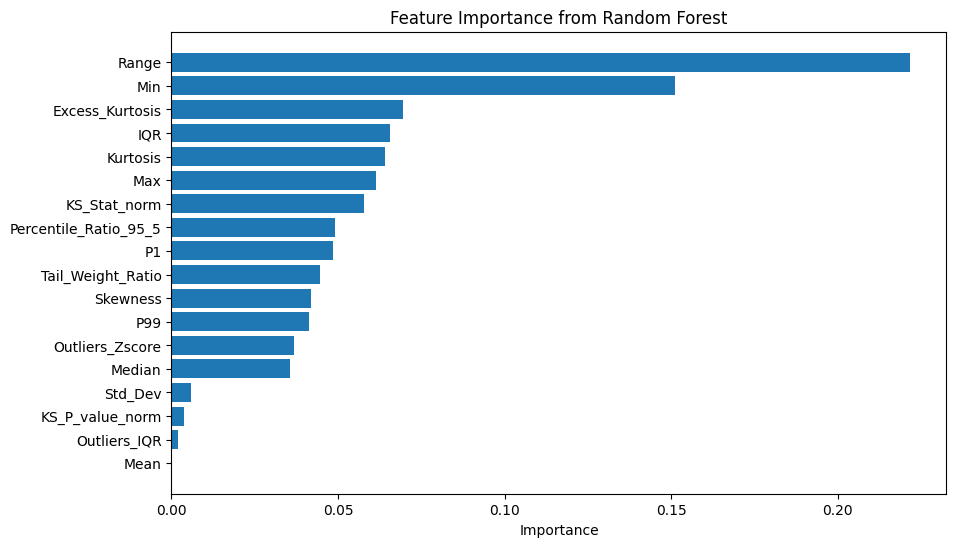

In [74]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

columns_to_drop = ['Target', 'Name', 'Distribution Type']
X = df_final_yk_nonull.drop(columns=columns_to_drop)  # Features
y = df_final_yk_nonull['Target']  

model = RandomForestClassifier()
model.fit(X, y)

importances = model.feature_importances_

importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=True)

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance from Random Forest')
plt.show()


## LUNA
Separate distribution type (target labels) into two distinct group. Aim is to group outlier and longtail distributions together, for binary classification task.

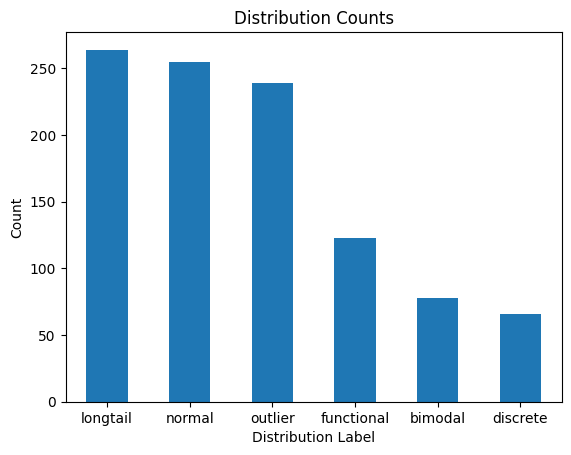

In [ ]:
distribution_counts = YK_model['Distribution Type'].value_counts()

import matplotlib.pyplot as plt

distribution_counts.plot(kind='bar')
plt.title('Distribution Counts')
plt.xlabel('Distribution Label')
plt.xticks(rotation=0)
plt.ylabel('Count')
plt.show()


In [ ]:
# Function to relabel target variable into binary values, where outlier and longtail are grouped together

def relabel_data(original_label):
    if original_label in ['outlier', 'longtail']:  
        return 'Outlier/Longtail'
    else:
        return 'Other'

In [ ]:
# New column added with the updated labels 
YK_model['new_label'] = YK_model['Distribution Type'].apply(relabel_data)

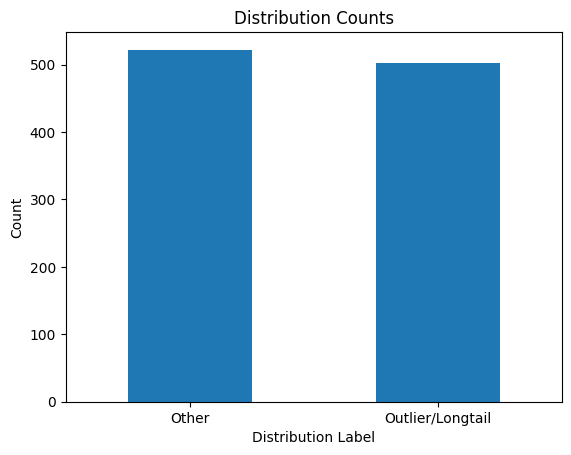

In [ ]:
binary_distribution_counts = YK_model['new_label'].value_counts()

binary_distribution_counts.plot(kind='bar')
plt.title('Distribution Counts')
plt.xlabel('Distribution Label')
plt.xticks(rotation=0)
plt.ylabel('Count')
plt.show()

In [ ]:
df_binary = YK_model[['Data','new_label']]
df_binary.shape
#1025 data points (tests), each with 50000 features (test values)

(1025, 2)

# Feature engineering for statistical properties
Create new features that describe the data, intend to train model solely using these features without the test values. 

<AxesSubplot:ylabel='Count'>

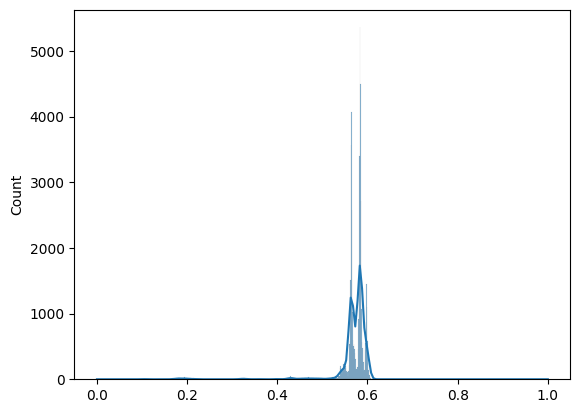

In [ ]:
import seaborn as sns

pd.Series(df_binary['Data'][1]).describe()
sns.histplot(df_binary['Data'][1], kde=True)

((array([-4.19138481, -3.98563638, -3.8734641 , ...,  3.8734641 ,
          3.98563638,  4.19138481]),
  array([0.        , 0.08269145, 0.08326201, ..., 1.        , 1.        ,
         1.        ])),
 (0.029056659240855008, 0.5695079374006602, 0.6311679073562934))

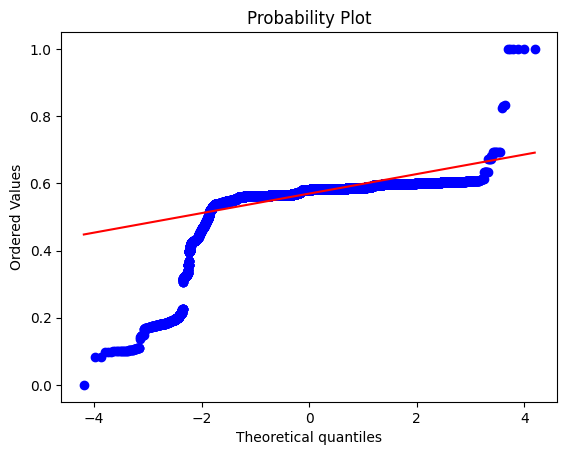

In [ ]:
import scipy.stats as stats


stats.probplot(pd.Series(df_binary['Data'][1]), dist="norm", plot=plt)

## Reducing feature space 
Propose to try different methods for reducing features:
1. PCA dimensionality reduction
2. Clustering using Kmeans, then sample from every cluster
3. Stratified sampling with binning

Propose to engineer new features (additional) regardless of method chosen above:
1. Mean/median/mode
2. Z-score and IQR labelling 
3. Skewness and kurtosis

At the end, to find out if:
1. Is converting feature space to just the additional features (solely statistical parameters or outlier statistics) without the test data better?
2. For blunderbuss with 6 different classes, how to balance data set? (previous method was trimming)
3. Is model necessary? Or is pipeline of statisical analysis enough to classify the exact distribution?
4. Is there a way to standardize the labelling of distribution? (currently based on 3 employees' judgements) -> this is to prevent model from being trained just on their judgements, or even worse just on one of their judgements

# Binning with stratisfied sampling

In [ ]:
# Function to bin data based on quantiles
def bin_data(df, num_bins):
    new_df = []
    for index, row in df.iterrows():
        values = row['Data']
        label = row['new_label']

        if len(pd.unique(values)) <= 2:
            # Directly use the binary values since not enough unique values to granularly separate into bins
            binned_values = values.astype(int)
        else:
            binned_values = pd.qcut(values, num_bins, labels=False, duplicates='drop')

        new_df.append({
        'data': values,
        'bin': binned_values,
        'label': label
        })
    return pd.DataFrame(new_df)

In [ ]:
df_binned = bin_data(df_binary, 5000)

In [ ]:
df_binned[df_binned['label'] != 'Other']

,data,bin,label
1,"[0.399193055385744, 0.39744059991033953, 0.396...","[65, 64, 63, 1086, 1086, 1086, 1209, 1209, 120...",Outlier/Longtail
2,"[0.0, 0.0002055076037813399, 0.000308261405672...","[0, 3, 5, 7, 9, 11, 13, 15, 18, 20, 22, 24, 26...",Outlier/Longtail
84,"[0.3804993788936786, 0.3871456870753418, 0.428...","[1870, 2025, 3113, 4009, 2263, 2854, 4987, 182...",Outlier/Longtail
85,"[0.38633312616532045, 0.439285270354258, 0.468...","[1578, 2826, 3572, 3689, 2337, 2946, 4980, 179...",Outlier/Longtail
86,"[0.7492980162046248, 0.7903511002021304, 0.730...","[1377, 4484, 477, 3046, 4369, 373, 2418, 4319,...",Outlier/Longtail
...,...,...,...
983,"[0.3555555555555556, 0.3111111111111111, 0.377...","[12, 10, 13, 15, 13, 8, 16, 11, 12, 18, 7, 11,...",Outlier/Longtail
984,"[0.33890414229437726, 0.4501611555449443, 0.34...","[537, 1553, 627, 943, 420, 844, 1281, 1591, 50...",Outlier/Longtail
985,"[0.512159603902723, 0.6807921945536624, 0.5229...","[706, 1981, 785, 1324, 568, 829, 1796, 1954, 5...",Outlier/Longtail
986,"[0.4927363972530374, 0.6436872688853672, 0.506...","[663, 1911, 774, 1167, 550, 983, 1800, 1844, 6...",Outlier/Longtail


In [ ]:
len(df_binned['bin'][1])

50000

In [ ]:
def sample_from_bins(row, num_samples):
    data = row['data']
    bins = row['bin']
    
    data_array = np.array(data)
    bins_array = np.array(bins)
    
    unique_bins = np.unique(bins_array)
    
    sampled_data = []
    sampled_bins = []

    num_samples_per_bin = num_samples // len(unique_bins)
    
    for b in unique_bins:
        bin_indices = np.where(bins_array == b)[0]
        sampled_indices = np.random.choice(bin_indices, min(len(bin_indices), num_samples_per_bin), replace=False)

        sampled_data.extend(data_array[sampled_indices])
        sampled_bins.extend(bins_array[sampled_indices])
    
    # If the total number of sampled data points is less than num_samples, fill the remaining with data points
    if len(sampled_data) < num_samples:
        additional_samples = num_samples - len(sampled_data)
        additional_indices = np.random.choice(len(data_array), additional_samples, replace=False)
        sampled_data.extend(data_array[additional_indices])
        sampled_bins.extend(bins_array[additional_indices])
    
    return pd.Series({'data': sampled_data, 'bin': sampled_bins, 'label': row['label']})


In [ ]:
def apply_sampling(df, num_samples):
    df_sampled = df.apply(lambda row: sample_from_bins(row, num_samples), axis=1)
    return df_sampled

In [ ]:
df_sampled = apply_sampling(df_binned, 5000)

In [ ]:
print(df_sampled.head())

#Check if entries in data/bin has only 5000 values (downsampled)
len(pd.Series(df_sampled['data'][0]))

                                                data  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1  [0.10037901944002936, 0.0, 0.10037901944002936...   
2  [5.1376900945334976e-05, 0.0001027538018906699...   
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                                 bin             label  
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...             Other  
1  [0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, ...  Outlier/Longtail  
2  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...  Outlier/Longtail  
3  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...             Other  
4  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...             Other  


5000

In [ ]:
# failed code
def stratified_sampling(df, bin_col, sample_size):
    

    df[bin_col] = df[bin_col].apply(lambda x: tuple(x))
    num_bins = df[bin_col].nunique() #number of bins 
    samples_per_bin = sample_size // num_bins #number of data points to take from each bin

    df_sampled = df.groupby(bin_col, group_keys=False).apply(lambda x: x.sample(min(len(x), samples_per_bin)))
    return df_sampled

In [ ]:
sample_size = 5000
sampled_df = stratified_sampling(binned_df, 'bin', sample_size)

# PCA

In [ ]:
from sklearn.decomposition import PCA

#rows as chips and columns as tests
pca = PCA(n_components=5000)
reduced_data = pca.fit_transform(data)